## pytorch自动微分

深度学习框架通过自动计算导数，即自动微分（automatic differentiation）来加快求导。 实际中，根据我们设计的模型，系统会构建一个计算图（computational graph）， 来跟踪计算是哪些数据通过哪些操作组合起来产生输出。 自动微分使系统能够随后反向传播梯度。 这里，反向传播（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

  - 实际上是数值求导，数值化表示微分。
  - 链式法则：$\frac{\partial{y}}{\partial{x}} = \frac{\partial{y}}{\partial{u_n}} \frac{\partial{u_n}}{\partial{u_{n-1}}}...\frac{\partial{u_2}}{\partial{u_1}} \frac{\partial{u_1}}{\partial{x}}$
  - 计算图：将代码分解成操作子，将计算表示成一个无环图。
    - 显式构造：Tensorflow/Theano/MXNet
    - 隐式构造：PyTorch/MXNet
  - 自动求导的两种模式：计算顺序的不同
    - 正向累积：$\frac{\partial{y}}{\partial{x}} = \frac{\partial{y}}{\partial{u_n}} (\frac{\partial{u_n}}{\partial{u_{n-1}}}(...(\frac{\partial{u_2}}{\partial{u_1}} \frac{\partial{u_1}}{\partial{x}})))$
    - 反向累积（反向传播）：$\frac{\partial{y}}{\partial{x}} = (((\frac{\partial{y}}{\partial{u_n}} \frac{\partial{u_n}}{\partial{u_{n-1}}})...\frac{\partial{u_2}}{\partial{u_1}})\frac{\partial{u_1}}{\partial{x}}$
  - 流程：
    - 构造计算图
    - 前向：执行图，存储中间结果
    - 反向：从相反的方向执行图，传播梯度
  - 复杂度：
    - 计算：O(n)，n是操作子个数
    - 内存：O(n)，需要存储正向的中间结果

### 1.一个简单的例子
对函数$y = 2x^Tx$关于列向量x求导

In [10]:
import torch

x = torch.arange(4.0)
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
x, x.grad               # 默认值是None

(tensor([0., 1., 2., 3.], requires_grad=True), None)

x.requires_grad_(True)代表需要存储梯度。注意，梯度更新并不变化梯度值的内存位置，不需要额外内存开销。

In [11]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

反向传播函数来自动计算y关于x每个分量的梯度

In [12]:
y.backward()
x.grad, x.grad==4*x

(tensor([ 0.,  4.,  8., 12.]), tensor([True, True, True, True]))

计算新梯度时，需要清除之前的值，因为默认情况下，pytorch会累积梯度。

In [13]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### 2.非标量的反向传播

向量y关于向量x的导数的最自然解释是一个Jacobi矩阵。 对于高阶和高维的y和x，求导的结果可以是一个高阶张量。

我们的目的不是计算微分矩阵，而是批量中每个样本单独计算的偏导数之和。

In [14]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 在我们的例子中，我们只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### 3.分离计算

有时，我们希望将某些计算移动到记录的计算图之外。 例如，假设y是作为x的函数计算的，而z则是作为y和x的函数计算的。 想象一下，我们想计算z关于x的梯度，但由于某种原因，我们希望将y视为一个常数， 并且只考虑到x在y被计算后发挥的作用。

在这里，我们可以分离y来返回一个新变量u，该变量与y具有相同的值， 但丢弃计算图中如何计算y的任何信息。 换句话说，梯度不会向后流经u到x。 因此，下面的反向传播函数计算z=u\*x关于x的偏导数，同时将u作为常数处理， 而不是z=x\*x\*x关于x的偏导数。

In [15]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [16]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

### 4.python控制流的梯度

使用自动微分的一个好处是： 即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度。

In [18]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad == d/a

tensor(True)

这就是隐式构建计算图的好处，对于控制流更友好一些；相对应的，也会更慢一些。

### 5.练习

  - 计算二阶导数的开销为什么比一阶导数更大？计算二阶导数是在计算一阶导数的基础上进行的。
  - 在运行反向传播函数之后，立即再次运行它，看看会发生什么。

In [22]:
x = torch.arange(4.0,requires_grad=True)
y = 2 * x * x
y.sum().backward()
print(x.grad)
y.sum().backward()
print(x.grad)

tensor([ 0.,  4.,  8., 12.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [21]:
x = torch.arange(4.0,requires_grad=True)
y = 2 * x * x
y.sum().backward(retain_graph=True)
print(x.grad)
y.sum().backward()
print(x.grad)

tensor([ 0.,  4.,  8., 12.])
tensor([ 0.,  8., 16., 24.])


  - 在控制流的例子中，我们计算d关于a的导数，如果我们将变量a更改为随机向量或矩阵，会发生什么？

In [24]:
a = torch.randn(size=(4,), requires_grad=True)
d = f(a)
print(d)
# d.backward()   <==== runtime err if d is a vector or matrix: grad can be implicitly created only for scalar outputs
d.sum().backward()
print(a.grad)       # 关于向量的各个维度的偏导数

tensor([1209.3586, -628.6833,  -17.4224, -398.3232], grad_fn=<MulBackward0>)
tensor([512., 512., 512., 512.])


  - 使 f(x)=sin(x) ，绘制 f(x) 和 df(x)/dx 的图像，其中后者不使用 f′(x)=cos(x) 。

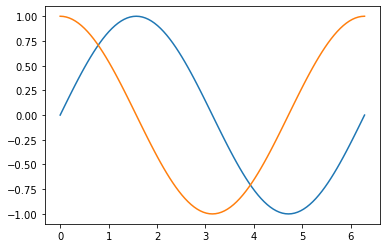

In [37]:
import matplotlib.pyplot as plt
x1 = torch.arange(101.0)
x1[:] = 2 * torch.pi * x1 / 100
x1.requires_grad_(True)
y1 = torch.sin(x1)
y1.sum().backward()
# 如果直接使用x1当横坐标，则会RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
x2 = x1.detach()
y2 = torch.sin(x2)
plt.plot(x2, y2)
plt.plot(x2, x.grad)
plt.show()